<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/autoencoders_with_ground_truth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import re
import glob
import re
import pandas as pd
import tensorflow as tf 
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#vamos a hacer un autoencoder que nos quita el ruido y la mierda de la imagen para que la clasifiacion luego sea mas sencilla
#primero la carga de datos, esta se hace de todos los elementos
#luego el procesado de datos, fill_holes
#por ultimo el entrenamiento, el input es la imagen del telescopio y la salida es la ground truth la cual nos dice la simulacion que no es ruido


In [ ]:
#funcion que nos suaviza todo para que la red asimile mejor las cosicas
def fill_holes(npy):
    npy_aux=npy.copy()
    if type(npy)!=np.ndarray:
        print("Error input")
        return
    #para cada elemento que sea cero lo rellenamos con la media de los vecinos
    indices=np.where(npy[1:-1,1:-1]==0)
    indices_1=indices[1]+1
    indices_0=indices[0]+1
    for i in range(indices_1.shape[0]):
        media=(npy[indices_0[i]-1,indices_1[i]]+npy[indices_0[i],indices_1[i]-1]+npy[indices_0[i]+1,indices_1[i]]+npy[indices_0[i],indices_1[i]+1])/4
        npy_aux[indices_0[i],indices_1[i]]=media
    return npy_aux

In [ ]:

def simple_load_dt_2_npy(file,verbose=False,save=False,save_events_id=False,npy_dir_aux=None,truth_sim=True,use_only_relev_events=True):
    num_pix_x=0
    num_pix_y=0
    verbose_list=[]
    dt_list=[]  
    nombre_archivo=re.findall("([a-zA-Z]*_tel_[0-9]*_run_\d\d).dt",file)[0]
    aux_df=pd.read_csv(file,sep='  ',names=["1","2","3","4","5","6"],engine="python")
    #ahora la procesamos y la guardamos en un np

    if truth_sim:
        value_auf=aux_df.loc[aux_df["6"]==1,["1","3","4","5","6"]]
        x_minimo=min(aux_df['3'])
        y_minimo=min(aux_df['4'])
        num_pix_x_aux=aux_df["3"].unique().size
        num_pix_y_aux=aux_df["4"].unique().size
        events=aux_df["1"].unique()
        auxiliar=aux_df.loc[aux_df["1"]==events[0]][["3","4","5"]].to_numpy()
        size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
        size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
    else:
        value_auf=aux_df.loc[:,['1','3','4','5']]
        x_minimo=min(value_auf['3'])
        y_minimo=min(value_auf['4'])
        num_pix_x_aux=value_auf["3"].unique().size
        num_pix_y_aux=value_auf["4"].unique().size
        events=value_auf["1"].unique()
        auxiliar=value_auf.loc[aux_df["1"]==events[0]][["3","4","5"]].to_numpy()
        size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
        size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
    #tenemos que agupar los valores 
    if use_only_relev_events:
        events=aux_df.loc[aux_df["6"]==1,"1"].unique()
    else:
        events=value_auf["1"].unique()
    del aux_df,auxiliar
    
    value_auf.loc[value_auf["5"]<0,"5"]=0

    if verbose:
        #print(num_pix_x,num_pix_y)
        verbose_list.append((num_pix_x_aux,num_pix_y_aux))
    ##!!!esto puede dar problemas si resulta que para el primer evento faltan datos o algo...
    #ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel

    if verbose:
        #print(nombre_archivo,end="\n")
        verbose_list.append(nombre_archivo)

    value_auf.loc[:,'3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/size_pix_x))
    value_auf.loc[:,'4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/size_pix_y))
    #event_aux=value_auf["1"].unique()
    for k in range(np.shape(events)[0]):
        #cada evento tiene que ponerse en una imagen con sus valores
        array_aux=value_auf.loc[value_auf["1"]==events[k],["3","4","5"]]
        #lo que vamos a hacer es poner los valores en una matriz creada de antemano y guardar esa matrix
        #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
        matrix_aux=np.zeros((num_pix_x_aux,num_pix_y_aux)) #eran 60-5= 55 y 131-38
        matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy() 
        dt_list.append(matrix_aux)

    if save:
        name_npy=f"{npy_dir_aux}/npy_sin_normal_{nombre_archivo}_{contador_nombre}.npy"
        np.save(name_npy,np.array(dt_list))
    if save_events_id:
        name_npy_events=f"{npy_dir_aux}/id_eventos_npy_sin_normal_{nombre_archivo}.npy"
        np.save(name_npy_events,np.array(events))
    if verbose:
        return verbose_list, np.array(dt_list)
    else:
        return np.array(dt_list)

In [ ]:
#funcion para la carga de datos
def get_dirs_autoencoder(dir,tels=None,elementos=None,runs=None,fold_pref="extract_",same_quant=True,num_runs=None):
    #primero buscamos las dirs
    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    dirs=[]
    for i,j in enumerate(elementos):
        for tel_aux,tel in enumerate(tels):
            if (tel_aux)*len(runs)>=num_runs[i]:
                pass
            else:
                for run_aux,run in enumerate(runs):
                    if num_runs is not None:
                        if num_runs[i]<(run_aux+1):
                            pass
                        else:
                            regrex=f"{dir}/{fold_pref}{j}/{j}_tel_{tel}_run_{str(run).zfill(2)}.dt"
                            aux_glob=glob.glob(regrex)
                            if aux_glob:
                                dirs.extend(aux_glob)
                    else:
                        regrex=f"{dir}/{fold_pref}{j}/{j}_tel_{tel}_run_{str(run).zfill(2)}.dt"
                        aux_glob=glob.glob(regrex)
                        if aux_glob:
                            dirs.extend(aux_glob)
    return dirs


def get_data_autoencoder(dir,tels=None,elementos=None,runs=None,fold_pref="extract_",same_quant=True,num_runs=None,channel_dim=True):
    dirs=get_dirs_autoencoder(dir,tels=tels,elementos=elementos,runs=runs,fold_pref=fold_pref,same_quant=same_quant,num_runs=num_runs)

    #ahora lo que hacemos es cargar los datos tanto puro como sucios,
    # los pasamos por fill holes y los devolvemos
    lista_clean=[]
    lista_dirty=[]
    for i in dirs:
        print(i)
        file_clean=simple_load_dt_2_npy(i,truth_sim=True,use_only_relev_events=True)
        file_dirty=simple_load_dt_2_npy(i,truth_sim=False,use_only_relev_events=True)
        #aplicamos fillholes
        file_clean=np.array([fill_holes(i) for i in file_clean])
        file_dirty=np.array([fill_holes(i) for i in file_dirty])
        if channel_dim:
            file_clean=file_clean[...,np.newaxis]
            file_dirty=file_dirty[...,np.newaxis]

        lista_clean.append(file_clean)
        lista_dirty.append(file_dirty)
    return np.concatenate(lista_clean),np.concatenate(lista_dirty)
        


In [ ]:
base_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
out=get_data_autoencoder(base_dir,tels=[5],runs=[3],num_runs=[0,0,0,0,1,1,1])

# Crear el autoencoder
Ya tenemos la funcion que nos va a dar los datos para entrenar un autoencoder convolucional


In [ ]:
#creamos un autoencoder convolucional
input_shape=(55,93,1)
input_img = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',padding="valid")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
#decoded=tf.keras.layers.LocallyConnected2D(1,(2,4),activation="relu")(x)
autoencoder = tf.keras.Model(input_img, decoded)
tf.keras.utils.plot_model(autoencoder,show_shapes=True)
autoencoder.summary()
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 55, 93, 1)]       0         
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 55, 93, 16)        160       
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 28, 47, 16)        0         
_________________________________________________________________
conv2d_431 (Conv2D)          (None, 28, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 14, 24, 32)        0         
_________________________________________________________________
conv2d_432 (Conv2D)          (None, 14, 24, 8)         2312      
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 7, 12, 8)          0  

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

#Entrenamos el modelo

In [ ]:
#cargamos la data
base_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
out=get_data_autoencoder(base_dir,tels=[4,5],runs=[1,2,3],num_runs=[1,1,3,3,3,3,3])

/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_gamma/gamma_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_gamma/gamma_tel_5_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_5_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_proton/proton_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_proton/proton_tel_4_run_02.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_proton/proton_tel_4_run_03.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_

In [ ]:
#la salida el out[8] tiene que tener shape 52,92 y ahora tiene 55 93
out_salida=out[0]
out_salida=out_salida[:,1:-2,1:]
x_train ,x_test=train_test_split(out[1],test_size=0.2,random_state=42)
y_train ,y_test=train_test_split(out_salida,test_size=0.2,random_state=42)

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=10)
hist=autoencoder.fit(x_train,y_train,epochs=45,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/45
279/279 [==============================] - 2s 6ms/step - loss: 56.5126 - val_loss: 25.9438
Epoch 2/45
279/279 [==============================] - 1s 5ms/step - loss: 24.8359 - val_loss: 18.3524
Epoch 3/45
279/279 [==============================] - 1s 5ms/step - loss: 18.6165 - val_loss: 15.6167
Epoch 4/45
279/279 [==============================] - 1s 5ms/step - loss: 15.3495 - val_loss: 18.4673
Epoch 5/45
279/279 [==============================] - 1s 5ms/step - loss: 13.9188 - val_loss: 14.1015
Epoch 6/45
279/279 [==============================] - 1s 5ms/step - loss: 12.2235 - val_loss: 14.6465
Epoch 7/45
279/279 [==============================] - 1s 5ms/step - loss: 13.3336 - val_loss: 11.7056
Epoch 8/45
279/279 [==============================] - 1s 5ms/step - loss: 11.2147 - val_loss: 11.7132
Epoch 9/45
279/279 [==============================] - 1s 5ms/step - loss: 10.7281 - val_loss: 10.6364
Epoch 10/45
279/279 [==============================] - 1s 5ms/step - loss: 10.3559

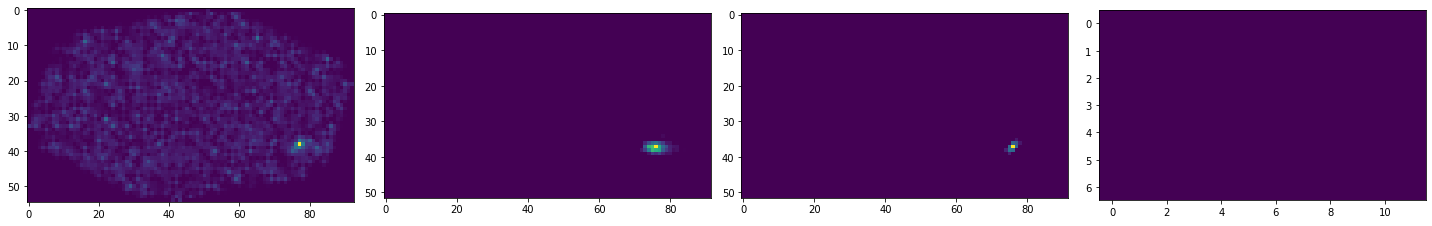

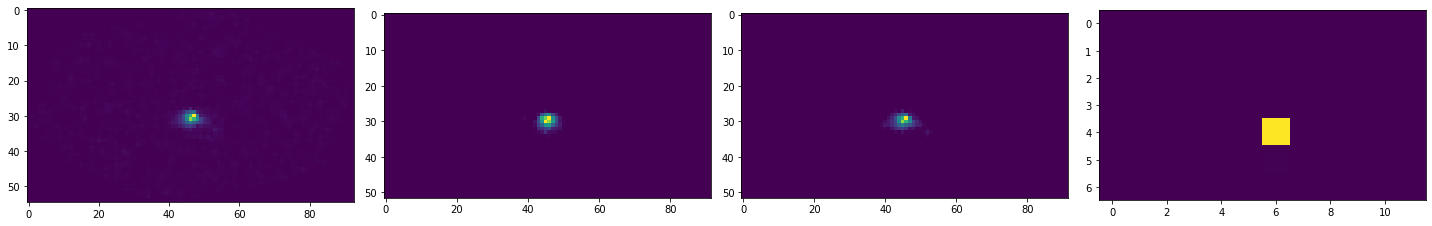

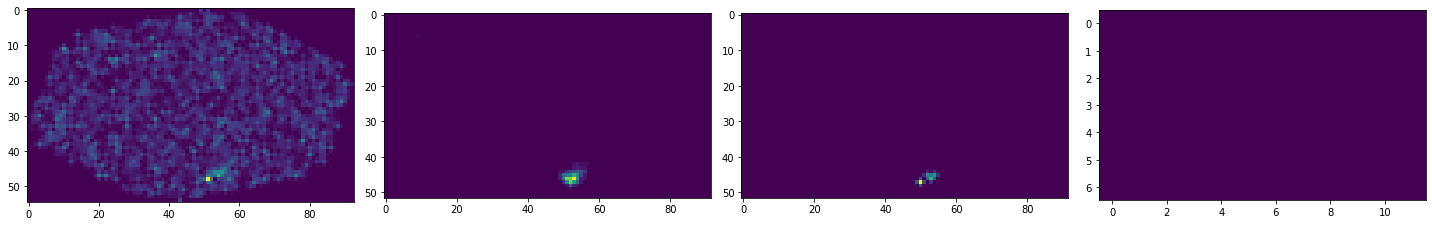

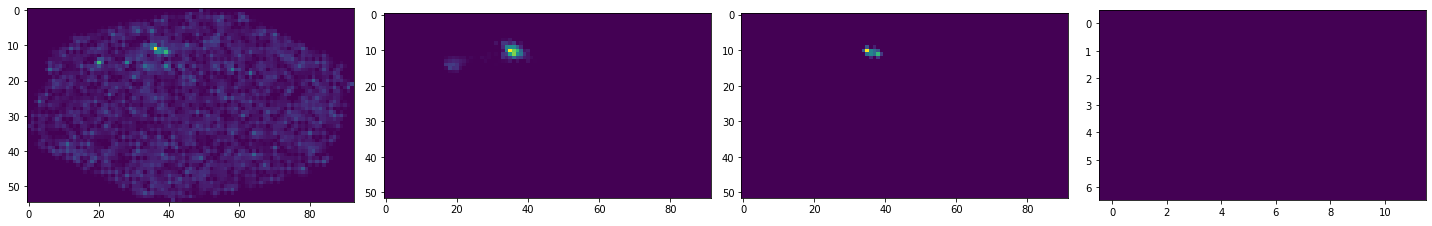

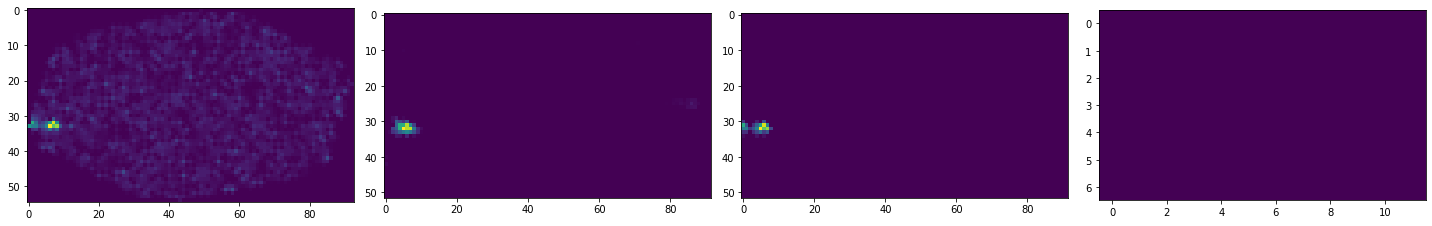

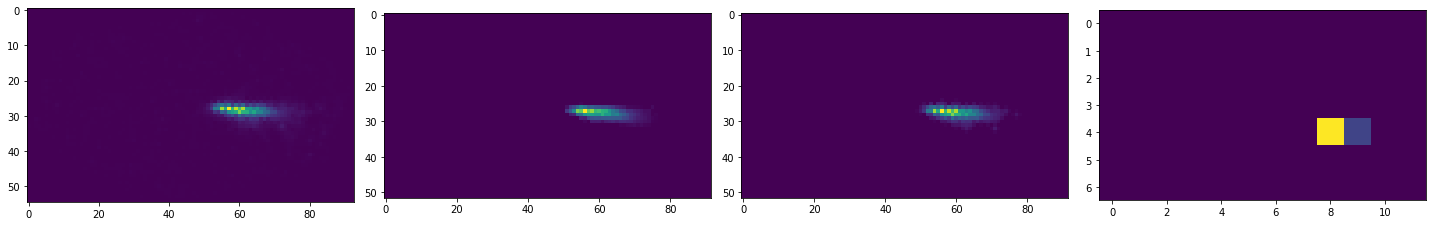

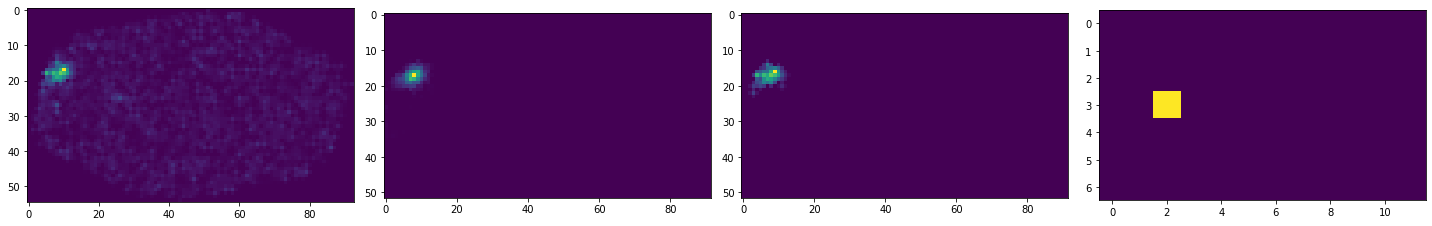

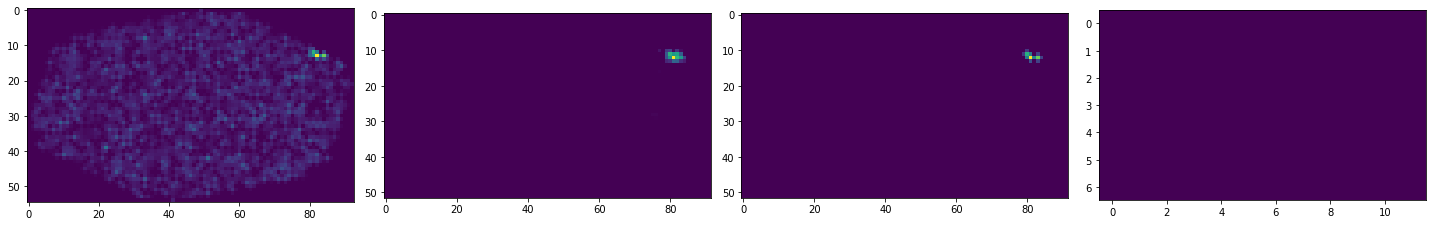

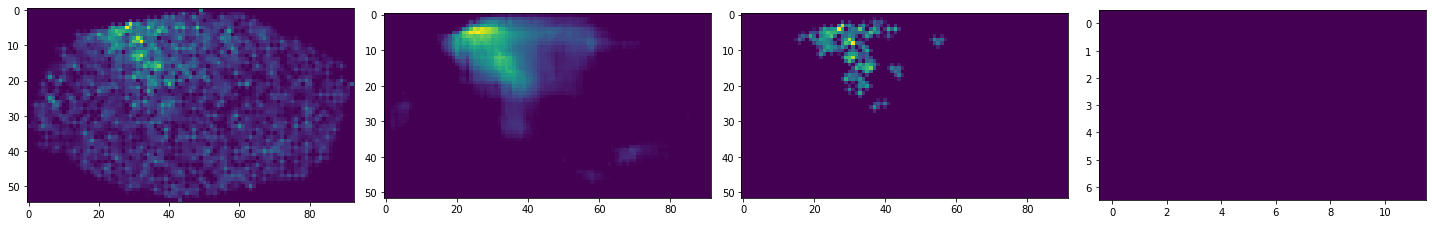

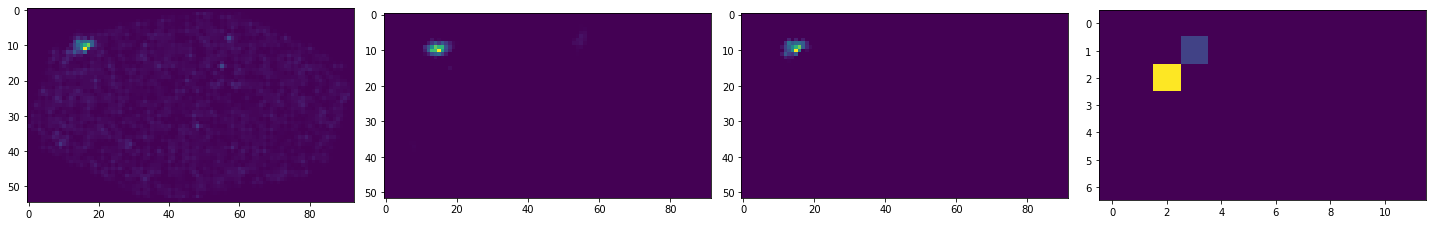

In [ ]:
predict_encod=encoder.predict(x_test[:78])
predict=autoencoder.predict(x_test[:78])
for i in range(10):
    plt.figure(figsize=(20,23))
    plt.subplot(1,4,1)
    plt.imshow(x_test[i][:,:,0])
    plt.subplot(1,4,2)
    plt.imshow(predict[i][:,:,0])
    plt.subplot(1,4,3)
    plt.imshow(y_test[i][:,:,0])
    plt.subplot(1,4,4)
    plt.imshow(predict_encod[i][:,:,0])
    plt.tight_layout()

In [ ]:
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
#autoencoder.save(f"{save_dir}/autoencoder_ground_truth_1_out5292.h5")
#encoder.save(f"{save_dir}/encoder_ground_truth_1.h5")

In [ ]:
#voy a ponerlo a entrenar con muchisimos datos y lo dejo entrenando

#cargamos la data
save_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"

base_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
autoencoder.compile(optimizer='adam', loss='mse')
stop=tf.keras.callbacks.EarlyStopping(patience=15)
h_m=[]
for i in range(1,18):
    if i==9:
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(5e-6), loss='mse')
    elif i==13:
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-6), loss='mse')
    elif i==16:
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(5e-7), loss='mse')

    out=get_data_autoencoder(base_dir,tels=[4,5,6,11],runs=[i],num_runs=[1,4,4,4,4,4,4])
    #la salida el out[0] tiene que tener shape 52,92 y ahora tiene 55 93
    out_salida=out[0]
    out_salida=out_salida[:,1:-2,1:]
    x_train ,x_test=train_test_split(out[1],test_size=0.2,random_state=42)
    y_train ,y_test=train_test_split(out_salida,test_size=0.2,random_state=42)
    del out, out_salida
    hist=autoencoder.fit(x_train,y_train,epochs=55,validation_data=(x_test,y_test),callbacks=[stop])
    h_m.append(hist)

#autoencoder.save(f"{save_dir}/autoencoder_ground_truth_2_largetrain_out5292.h5")
#encoder.save(f"{save_dir}/encoder_ground_truth_2_largetrain.h5")

/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_gamma/gamma_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_5_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_6_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_electron/electron_tel_11_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_proton/proton_tel_4_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/extract_proton/proton_tel_5_run_01.dt
/content/drive/MyDrive/prediccion_datos_muchos_telesco

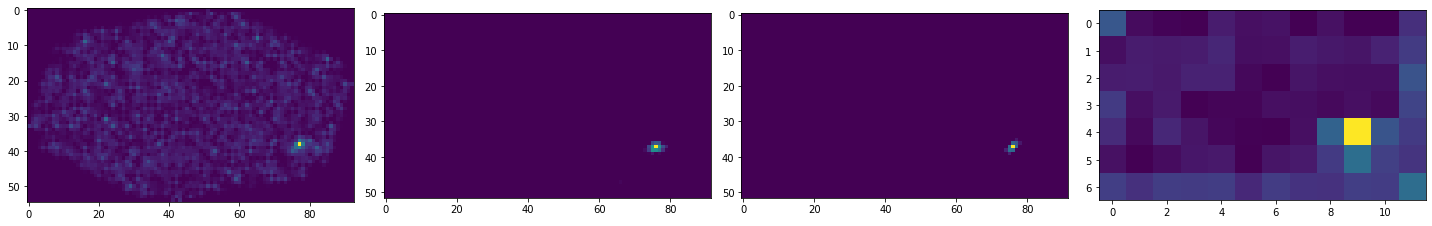

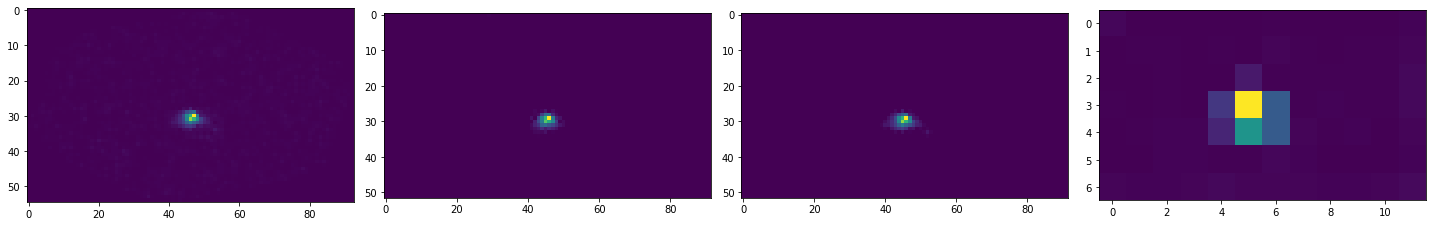

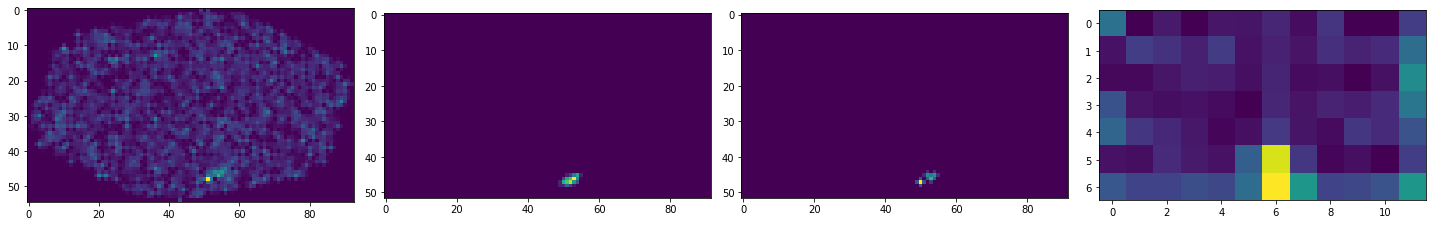

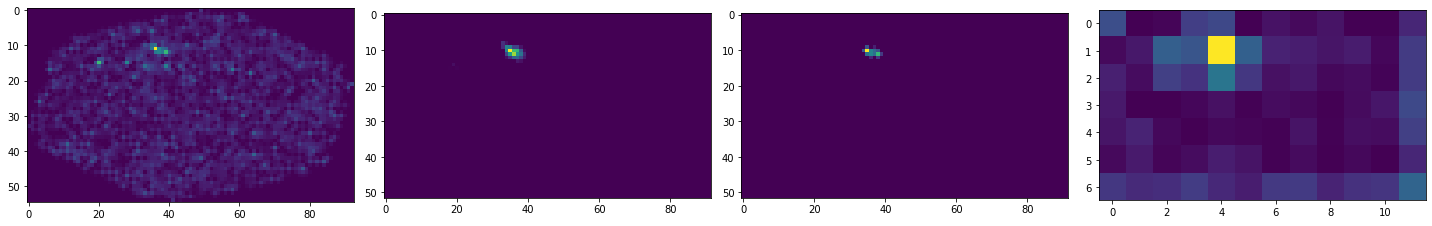

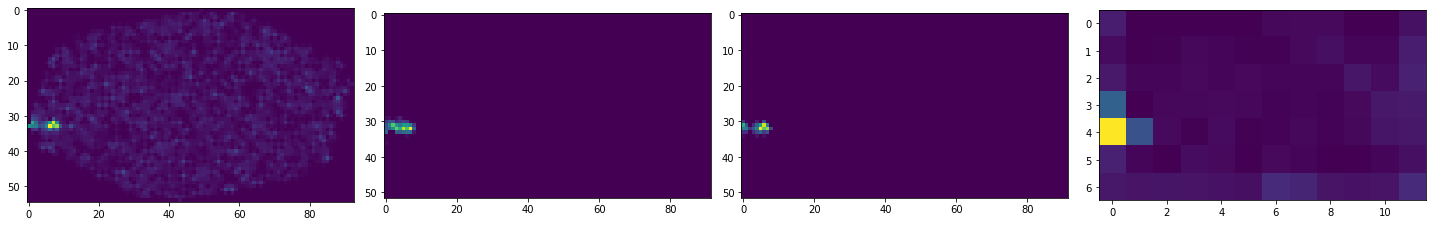

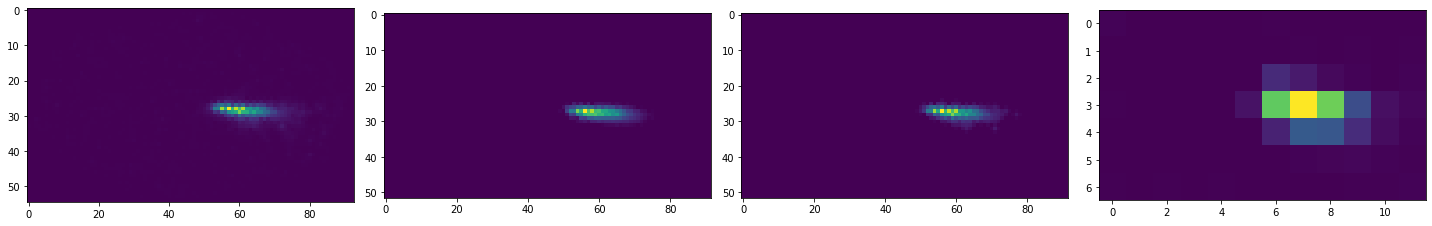

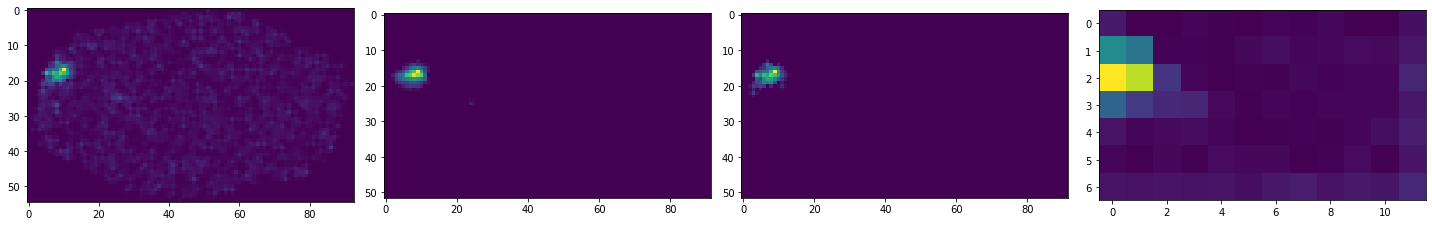

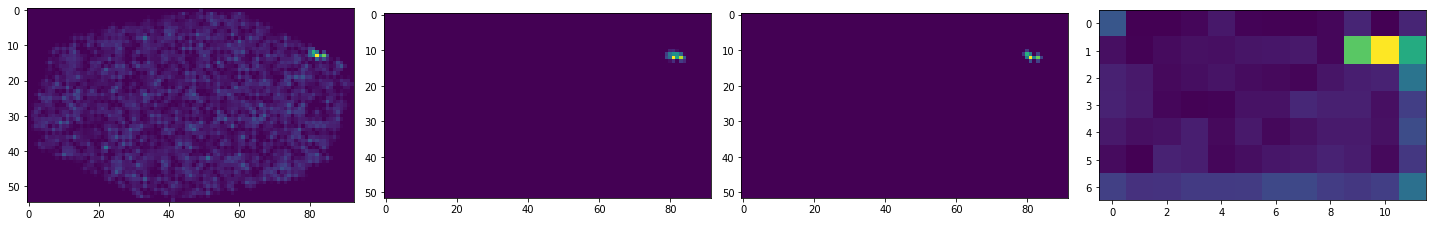

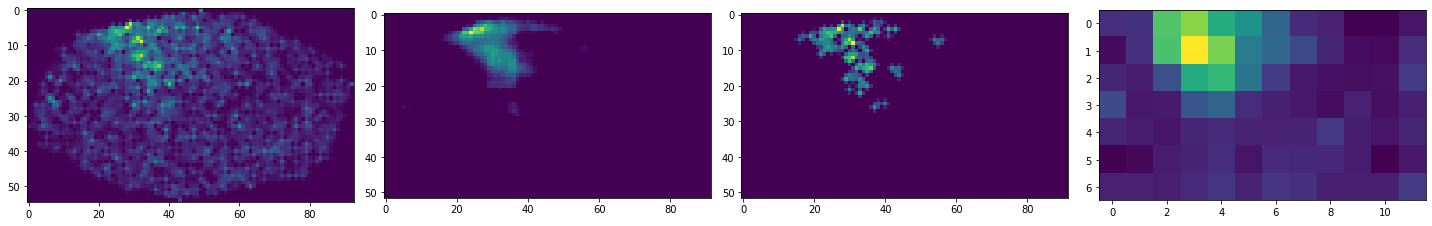

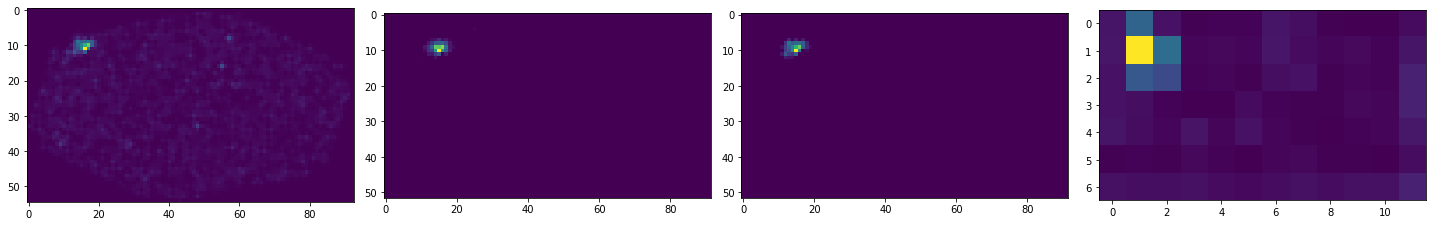

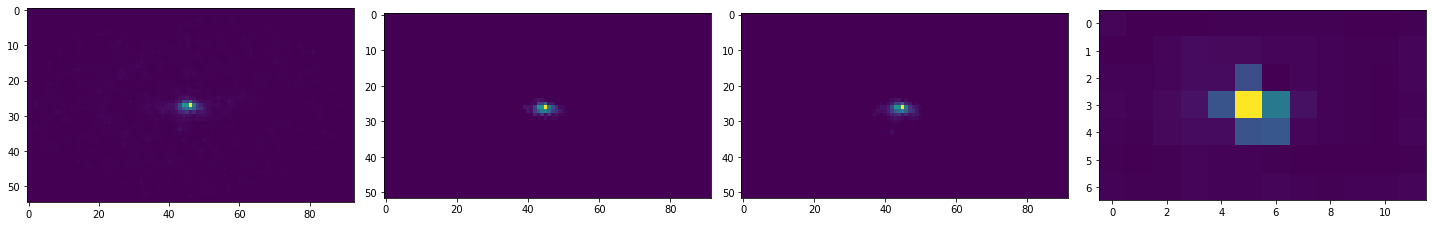

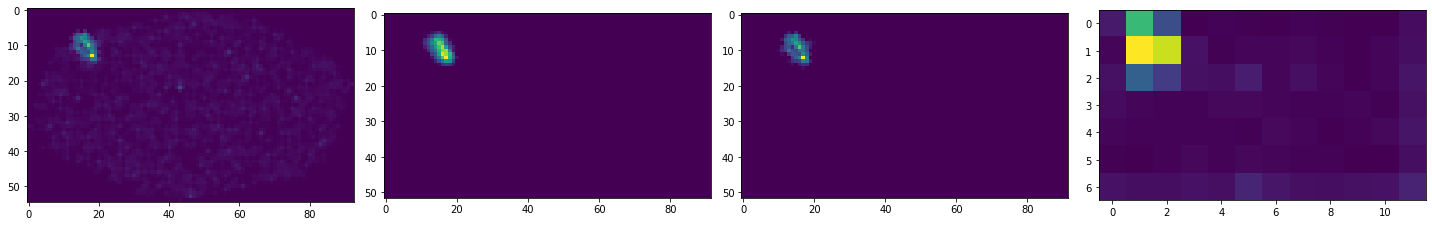

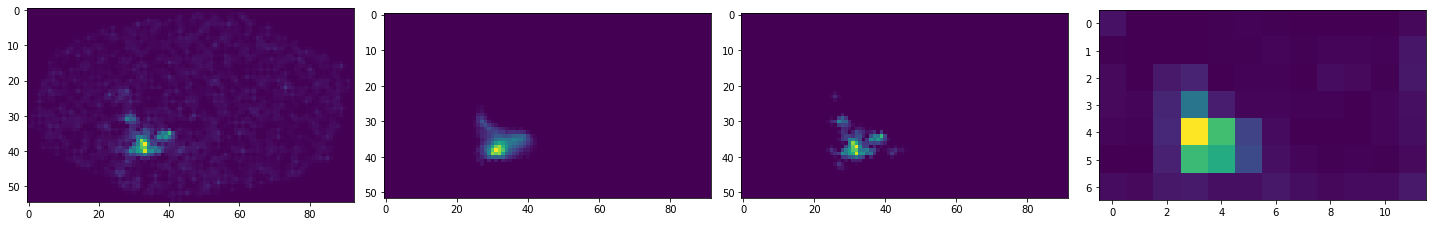

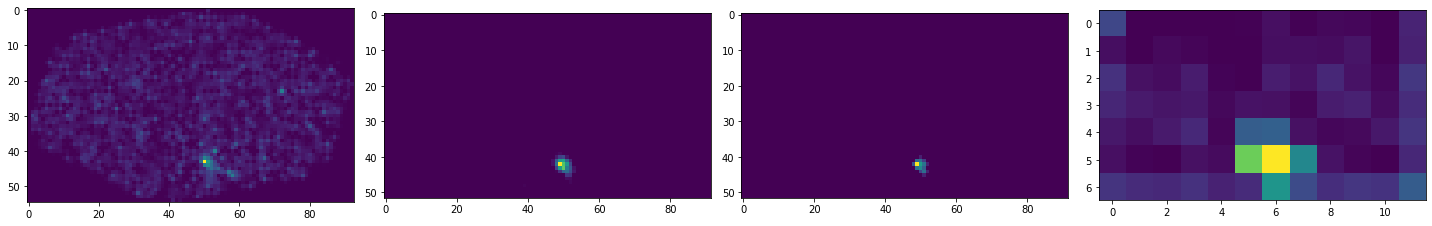

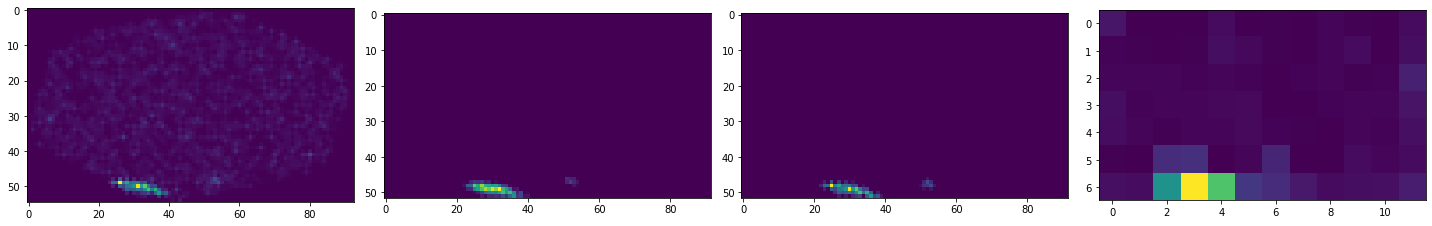

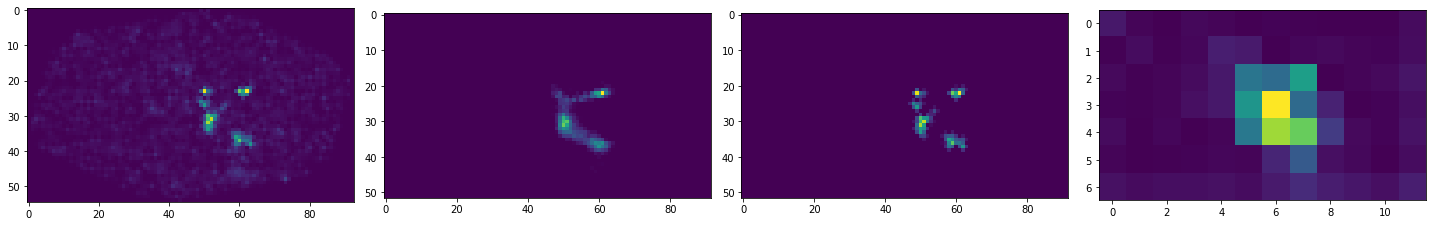

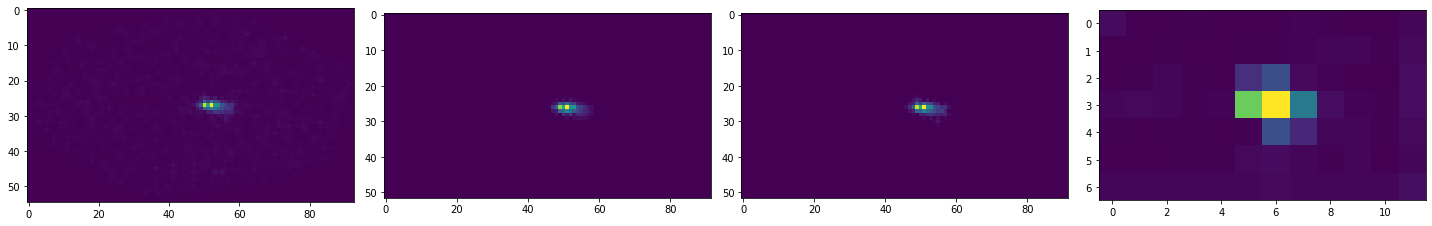

In [ ]:
predict_encod=encoder.predict(x_test[:78])
predict=autoencoder.predict(x_test[:78])
for i in range(17):
    plt.figure(figsize=(20,23))
    plt.subplot(1,4,1)
    plt.imshow(x_test[i][:,:,0])
    plt.subplot(1,4,2)
    plt.imshow(predict[i][:,:,0])
    plt.subplot(1,4,3)
    plt.imshow(y_test[i][:,:,0])
    plt.subplot(1,4,4)
    plt.imshow(predict_encod[i][:,:,0])
    plt.tight_layout()

# otra opcion con weiths limitators (sale mal)

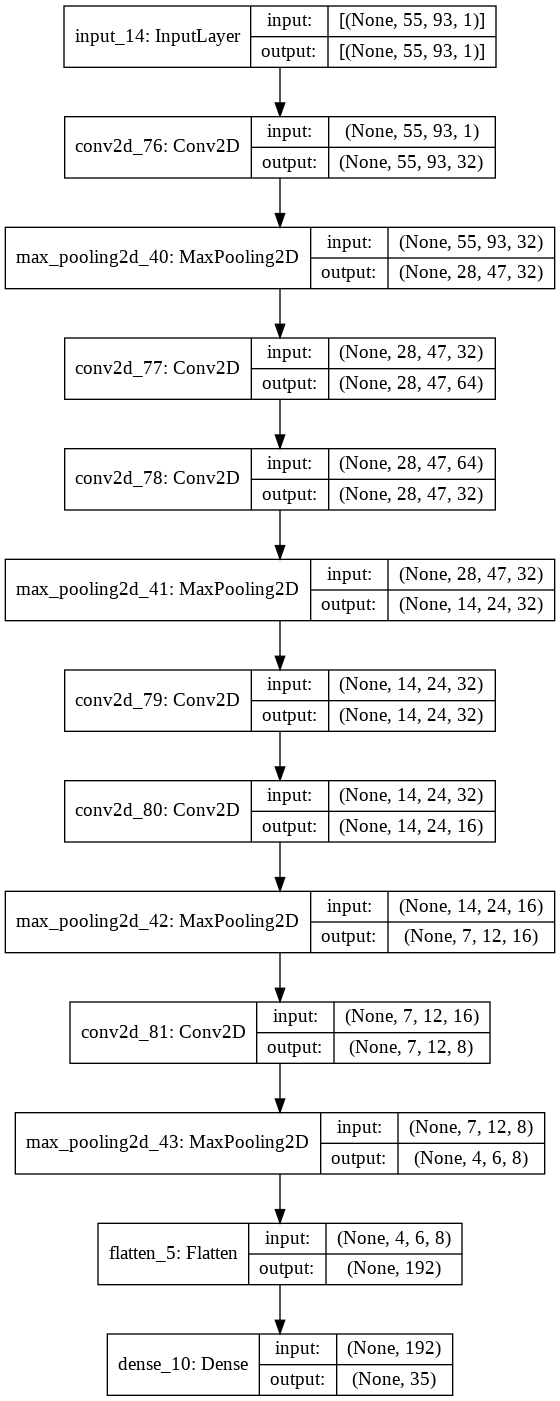

In [ ]:
tf.keras.utils.plot_model(encoder,show_shapes=True)


In [ ]:
#vamos a hacer lo anterior pero a hacer que se seleccione mucho mas los pesos en la capa central
#creamos un autoencoder convolucional
input_shape=(55,93,1)
input_img = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Flatten()(x)
encoded = tf.keras.layers.Dense(100,activation="relu")(x)
encoder2=tf.keras.Model(inputs=input_img,outputs=encoded)
encoder2.summary()
tf.keras.utils.plot_model(encoder2,show_shapes=True)


x = tf.keras.layers.Dense(192,activation="relu")(encoded)
x = tf.keras.layers.Reshape((4,6,8))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',padding="same")(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='valid')(x)
decoded  =tf.keras.layers.Cropping2D(((5,5),(1,1)))(x)
#decoded=tf.keras.layers.LocallyConnected2D(1,(2,4),activation="relu")(x)
autoencoder2 = tf.keras.Model(input_img, decoded)
tf.keras.utils.plot_model(autoencoder2,show_shapes=True)
autoencoder2.summary()

Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 55, 93, 1)]       0         
_________________________________________________________________
conv2d_329 (Conv2D)          (None, 55, 93, 32)        320       
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 28, 47, 32)        0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 28, 47, 64)        18496     
_________________________________________________________________
conv2d_331 (Conv2D)          (None, 28, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 14, 24, 32)        0         
_________________________________________________________________
conv2d_332 (Conv2D)          (None, 14, 24, 32)        924

In [ ]:
autoencoder2.compile(optimizer='adam', loss='mse')

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=20)
hist=autoencoder2.fit(x_train,y_train,epochs=45,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/45
351/351 [==============================] - 3s 7ms/step - loss: 29.5349 - val_loss: 25.1636
Epoch 2/45
351/351 [==============================] - 2s 7ms/step - loss: 31.2943 - val_loss: 19.5562
Epoch 3/45
351/351 [==============================] - 2s 7ms/step - loss: 21.4975 - val_loss: 26.5143
Epoch 4/45
351/351 [==============================] - 2s 7ms/step - loss: 23.2502 - val_loss: 17.7200
Epoch 5/45
351/351 [==============================] - 2s 7ms/step - loss: 19.2047 - val_loss: 17.2687
Epoch 6/45
351/351 [==============================] - 2s 7ms/step - loss: 18.3679 - val_loss: 18.2846
Epoch 7/45
351/351 [==============================] - 2s 7ms/step - loss: 18.0727 - val_loss: 16.1584
Epoch 8/45
351/351 [==============================] - 2s 7ms/step - loss: 17.9224 - val_loss: 26.1875
Epoch 9/45
351/351 [==============================] - 2s 7ms/step - loss: 19.6444 - val_loss: 15.9159
Epoch 10/45
351/351 [==============================] - 2s 7ms/step - loss: 15.9803

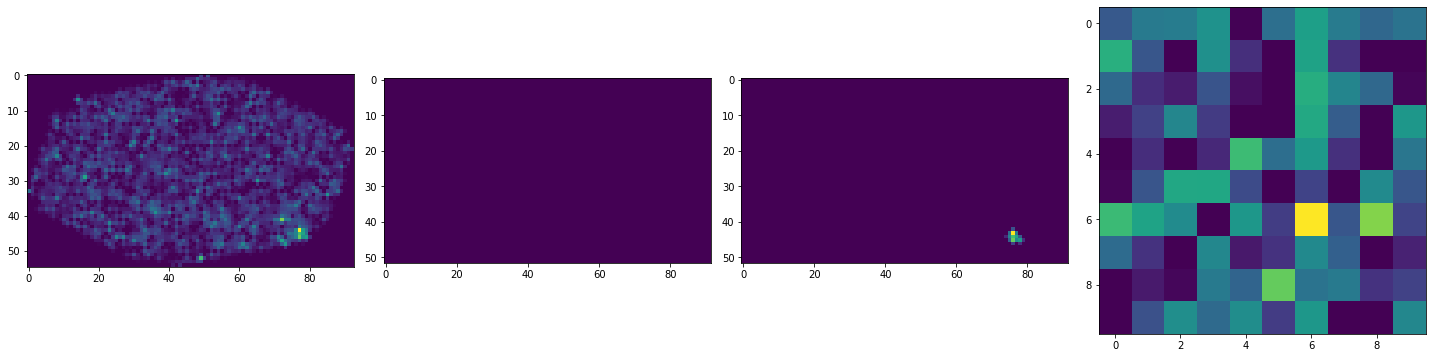

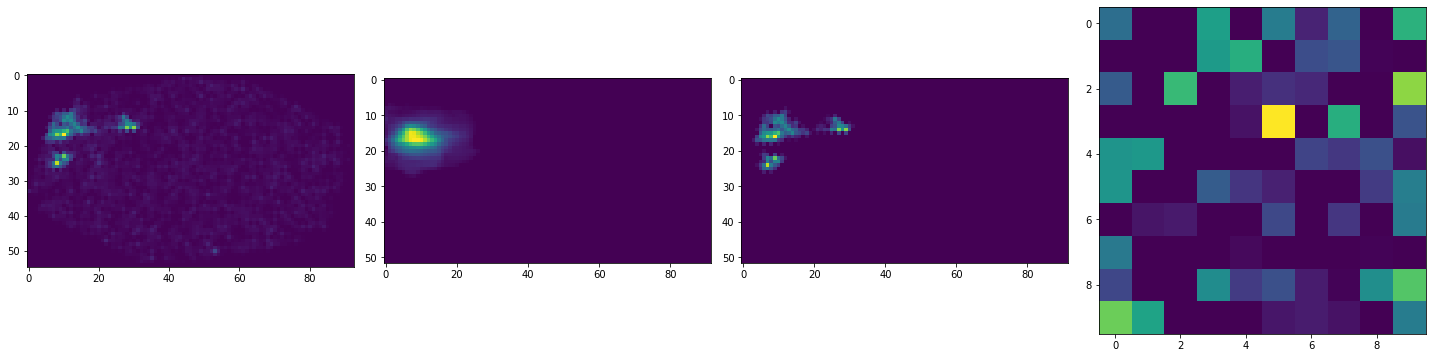

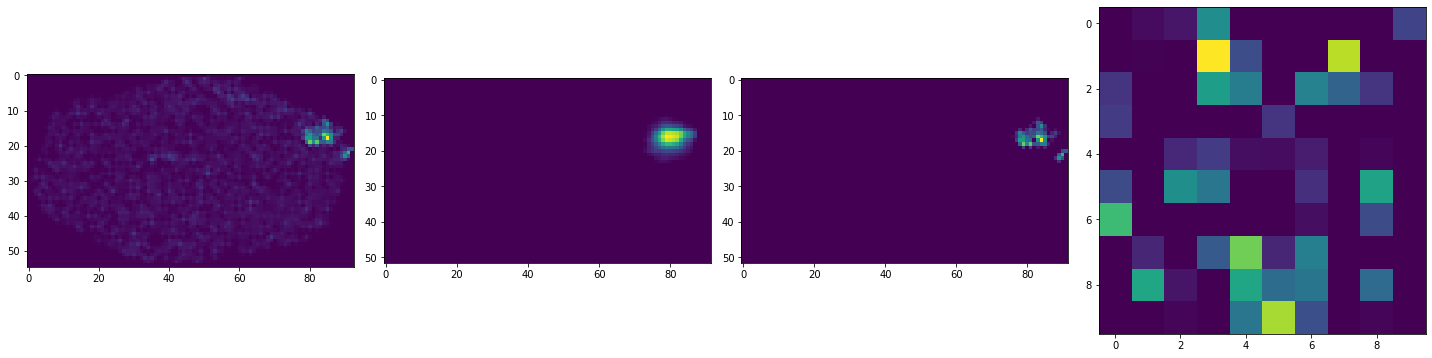

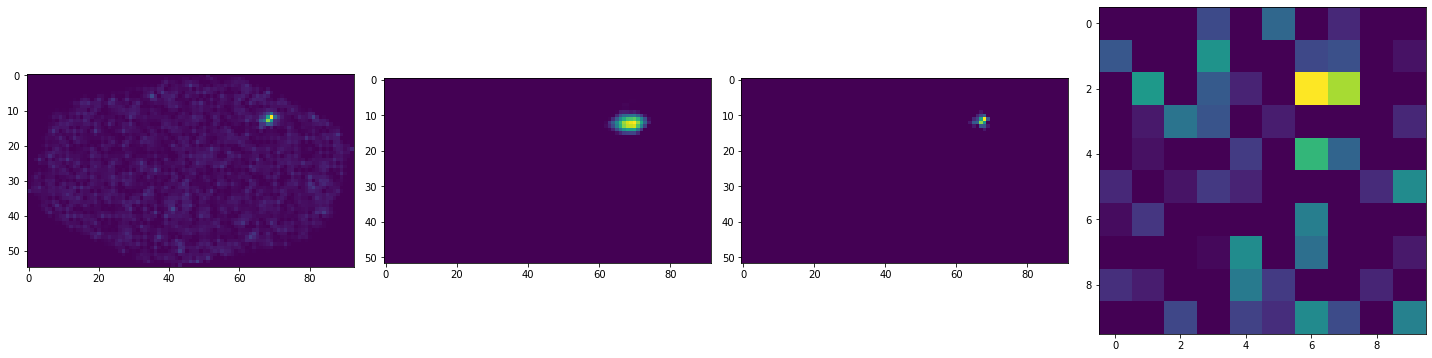

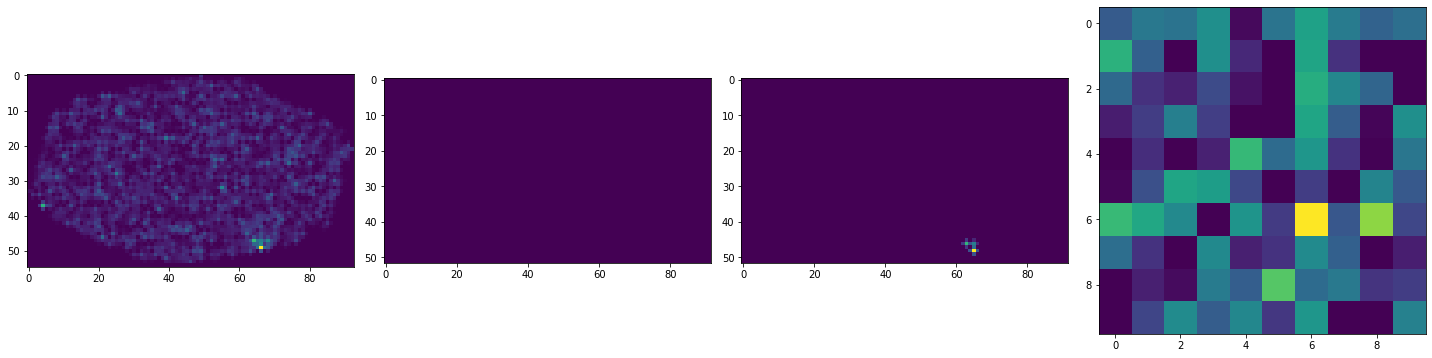

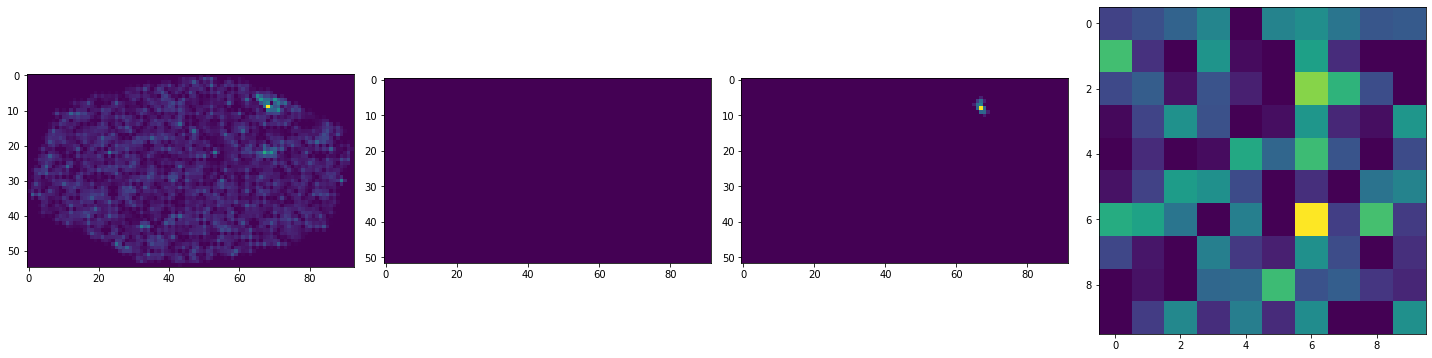

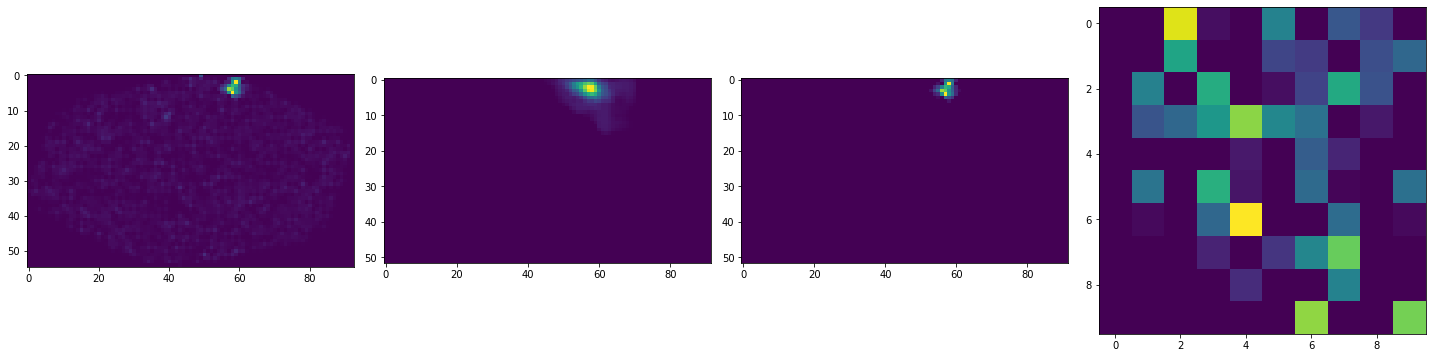

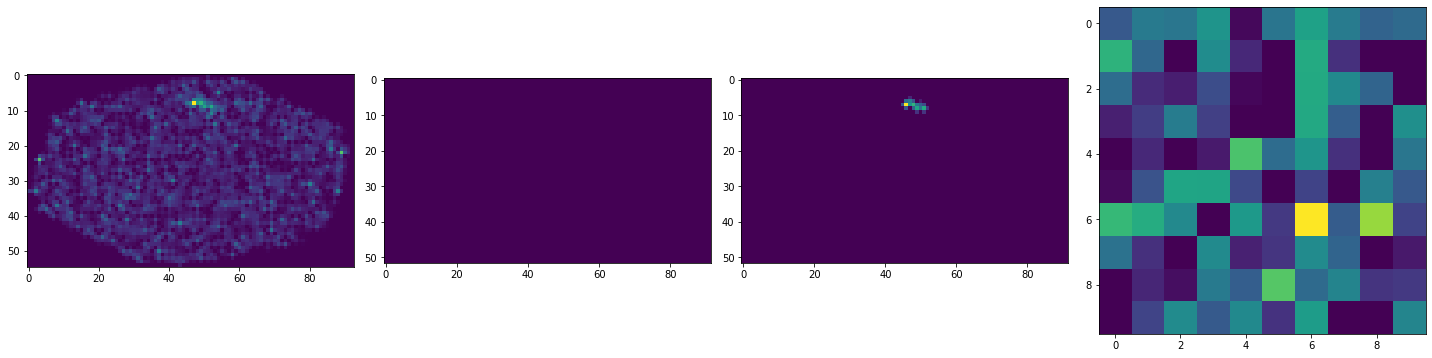

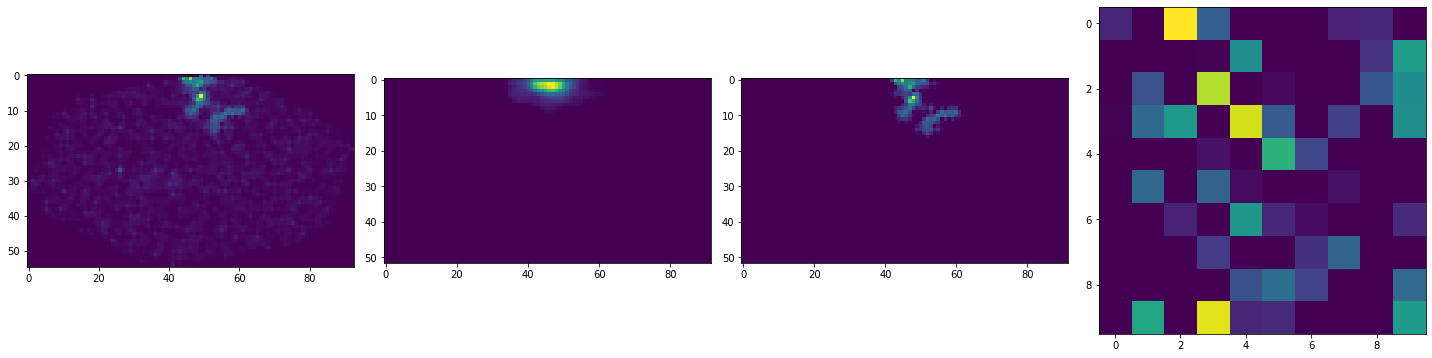

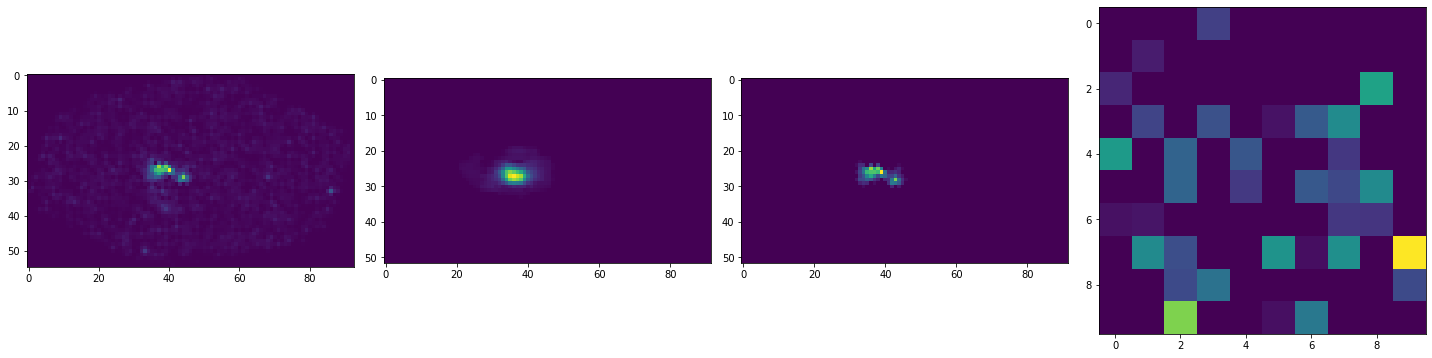

In [ ]:
predict_encod=encoder2.predict(x_test[:78])
predict=autoencoder2.predict(x_test[:78])
for i in range(10):
    plt.figure(figsize=(20,23))
    plt.subplot(1,4,1)
    plt.imshow(x_test[i][:,:,0])
    plt.subplot(1,4,2)
    plt.imshow(predict[i][:,:,0])
    plt.subplot(1,4,3)
    plt.imshow(y_test[i][:,:,0])
    plt.subplot(1,4,4)
    plt.imshow(predict_encod[i][np.newaxis,...].reshape((10,10)))
    plt.tight_layout()

queda claro que pasar a una deep layer en el centro no hace bien al autoencoder